<a href="https://colab.research.google.com/github/chris69-bit/Kaggle_Competition/blob/main/Simple_House_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
!pip install -q lazypredict
!pip install -q optuna
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import PowerTransformer as powerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor

from lazypredict.Supervised import LazyRegressor
import optuna
import xgboost as xgb
import lightgbm
import catboost



#Importing Dataset

In [ ]:
test_dataset = pd.read_csv('/content/test.csv')
train_dataset = pd.read_csv('/content/train.csv')


combine_dataset = pd.concat([train_dataset, test_dataset], sort=False)

In [ ]:
combine_dataset.shape

(2919, 81)

#Exploratory Data Analysis

##Checking Info

In [ ]:
combine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

##Checking Null Values

In [ ]:
combine_null = combine_dataset.isnull().sum()

combine_null.drop(labels='SalePrice', axis=0, inplace=True)

#Convert to DataFrame
missing_values = pd.DataFrame(data=combine_dataset.isna().sum(), index=combine_dataset.columns, columns=['missing'])

#Add Percentage Column
missing_values['Percentage'] = missing_values['missing'] / 2919 * 100

#Sort By Descending Order
missing_values = missing_values.sort_values(by='Percentage', ascending=False)

missing_values.head(10)

,missing,Percentage
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
MasVnrType,1766,60.50
SalePrice,1459,49.98
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageYrBlt,159,5.45


##Visualize Missing Values

<Axes: >

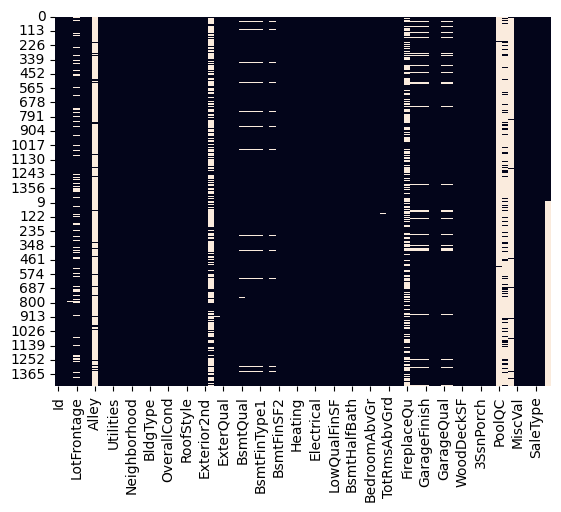

In [ ]:
#Visualizing Missing Values With HeatMaps
sns.heatmap(combine_dataset.isnull(), cbar=False)

##Checking Data Distribution

In [ ]:
#First Let's Split the data into numerical, categorical

numerical_data = combine_dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_data = combine_dataset.select_dtypes(include='object').columns.tolist()

#Drop Id and SalesPrice
numerical_data = [col for col in numerical_data if col not in ['Id', 'SalePrice']]

#Further Split Numerical data into discrete and continuous data
discrete_data = [col for col in numerical_data if len(combine_dataset[col].unique()) > 25]
continuous_data = [col for col in numerical_data if col not in discrete_data]

print(f'Number of Categorical Feature : {len(categorical_data)}')
print(f'Number of Numerical Feature   : {len(numerical_data)}')
print(f'Number of Discrete Feature    : {len(discrete_data)}')
print(f'Number of Continous Feature   : {len(continuous_data)}')

Number of Categorical Feature : 43
Number of Numerical Feature   : 36
Number of Discrete Feature    : 21
Number of Continous Feature   : 15


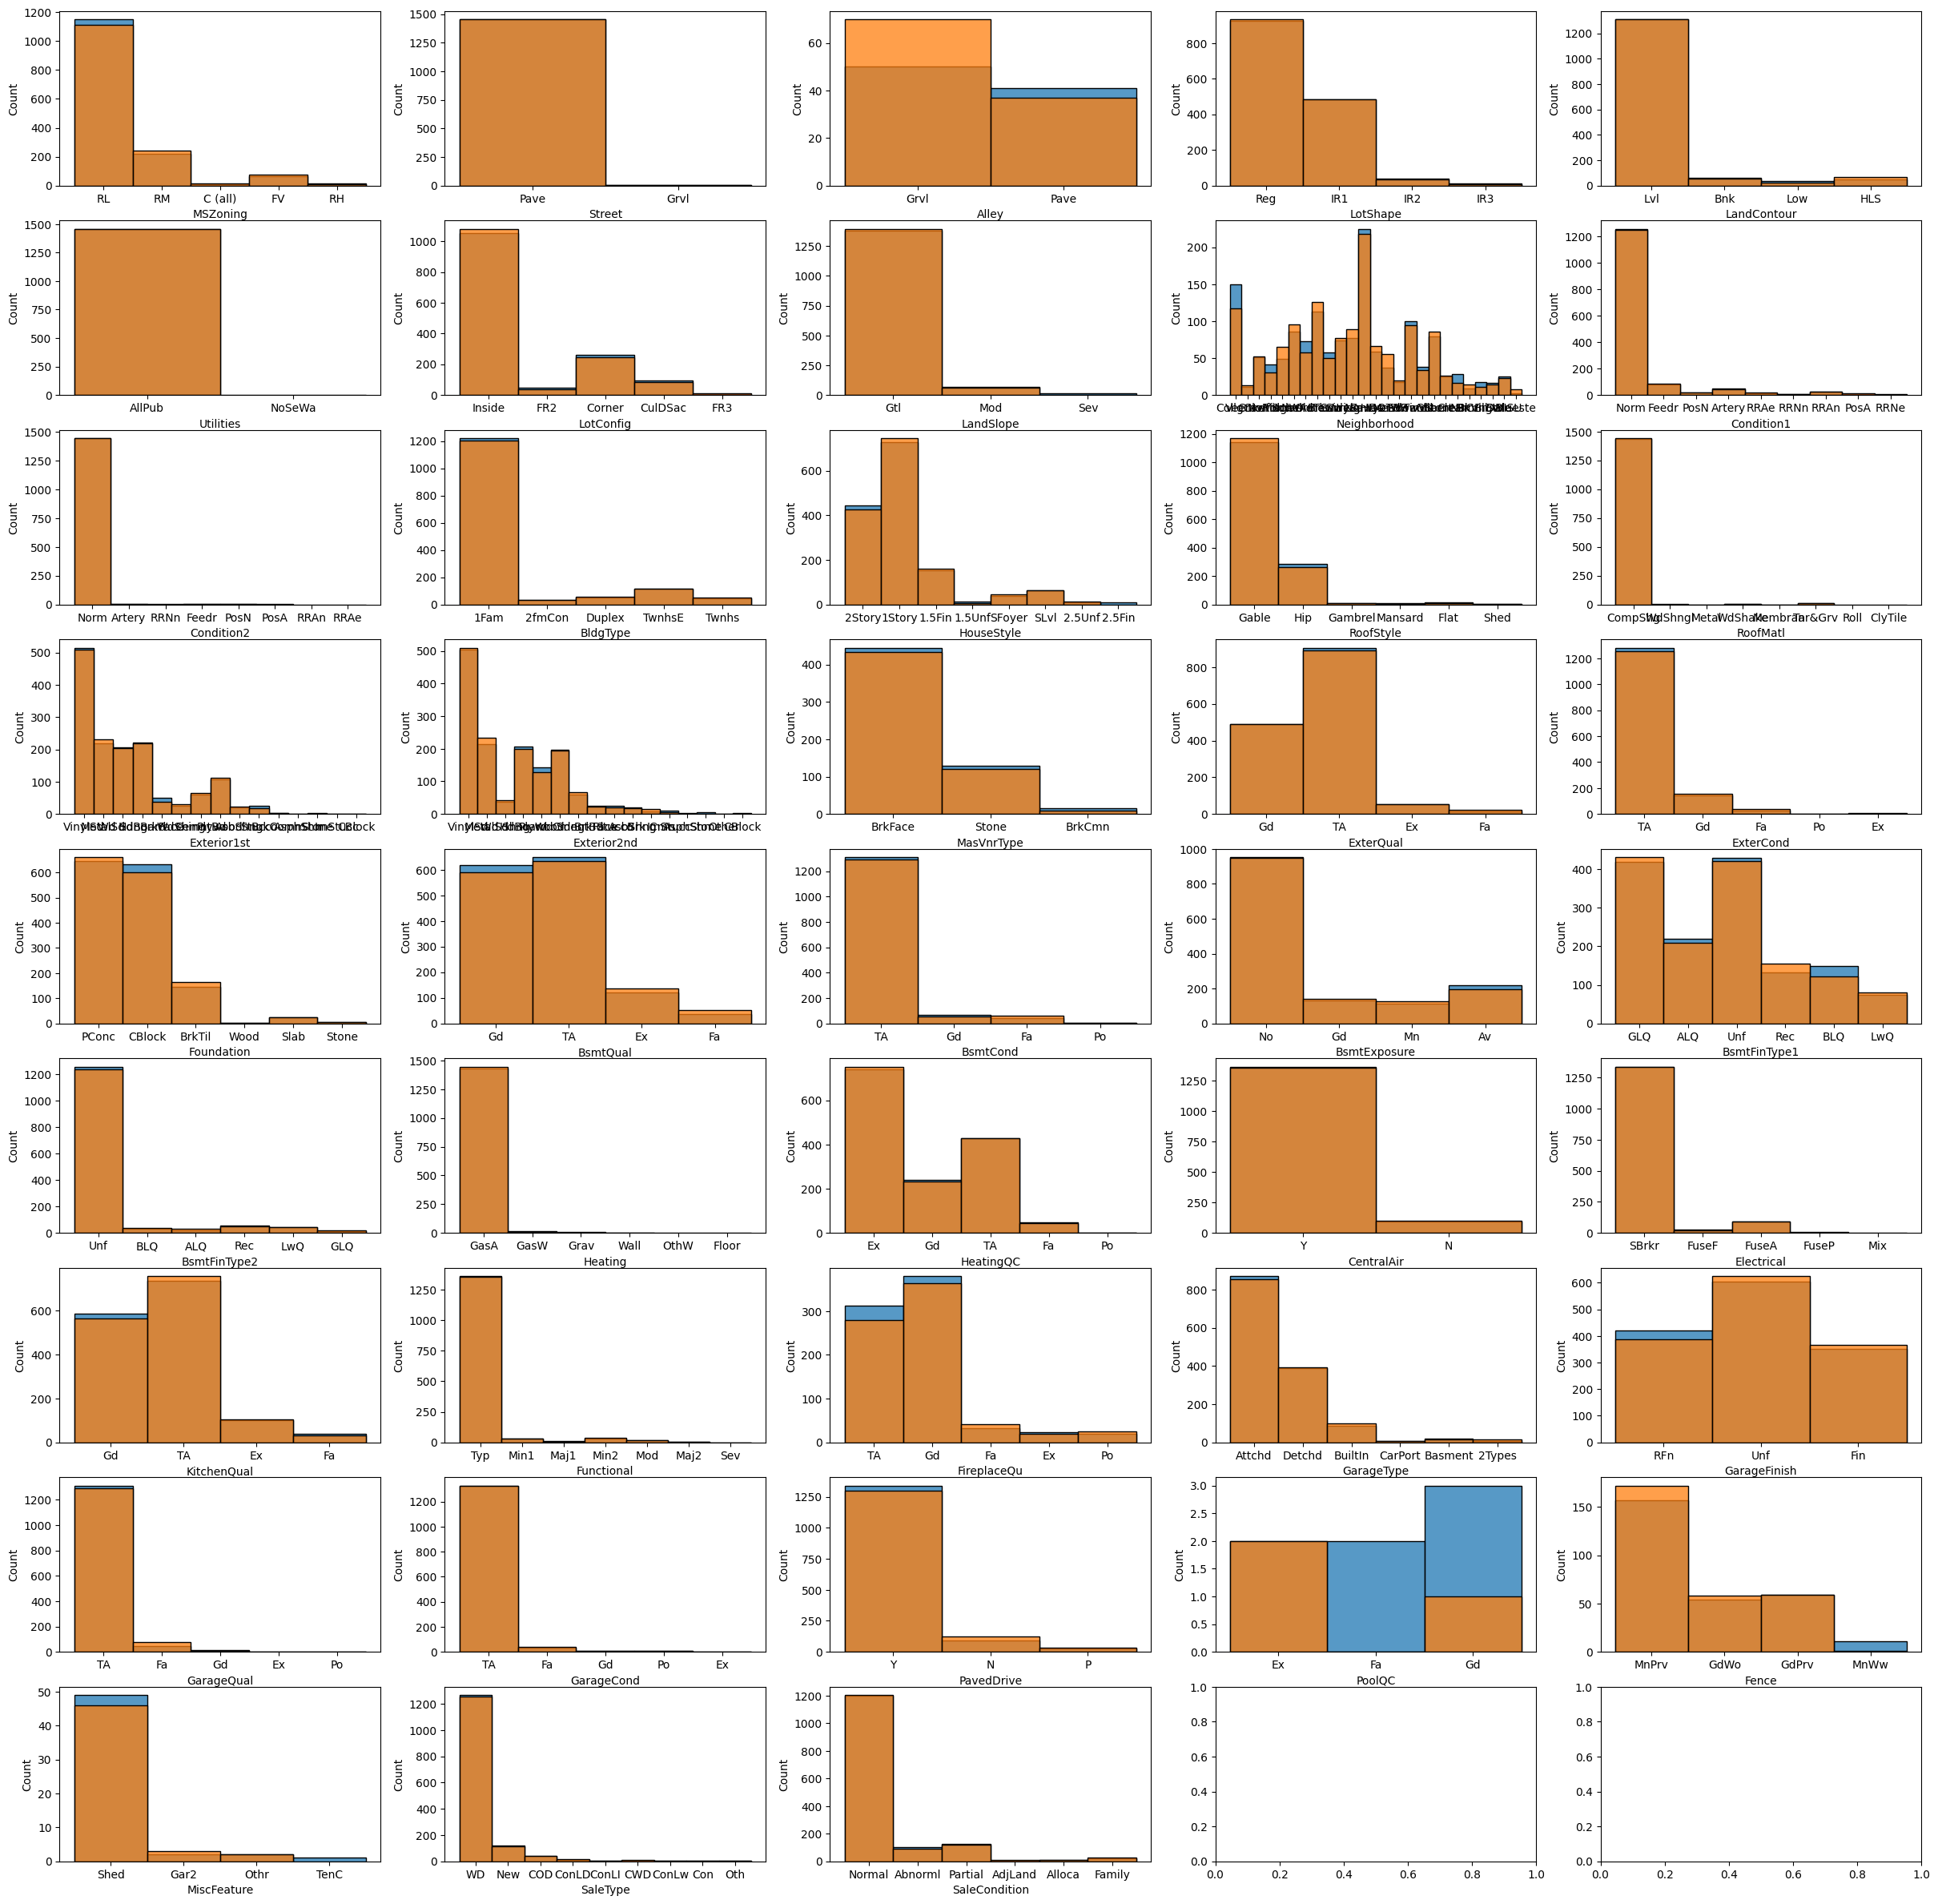

In [ ]:
#Visualize Distribution Of Categorical Feature
fig , axes = plt.subplots(nrows=9, ncols=5, figsize=(30,30))

for i, feature in enumerate(categorical_data):
  sns.histplot(x=feature, data=train_dataset, ax=axes[i//5, i%5])
  sns.histplot(x=feature, data=test_dataset, ax=axes[i//5, i%5])


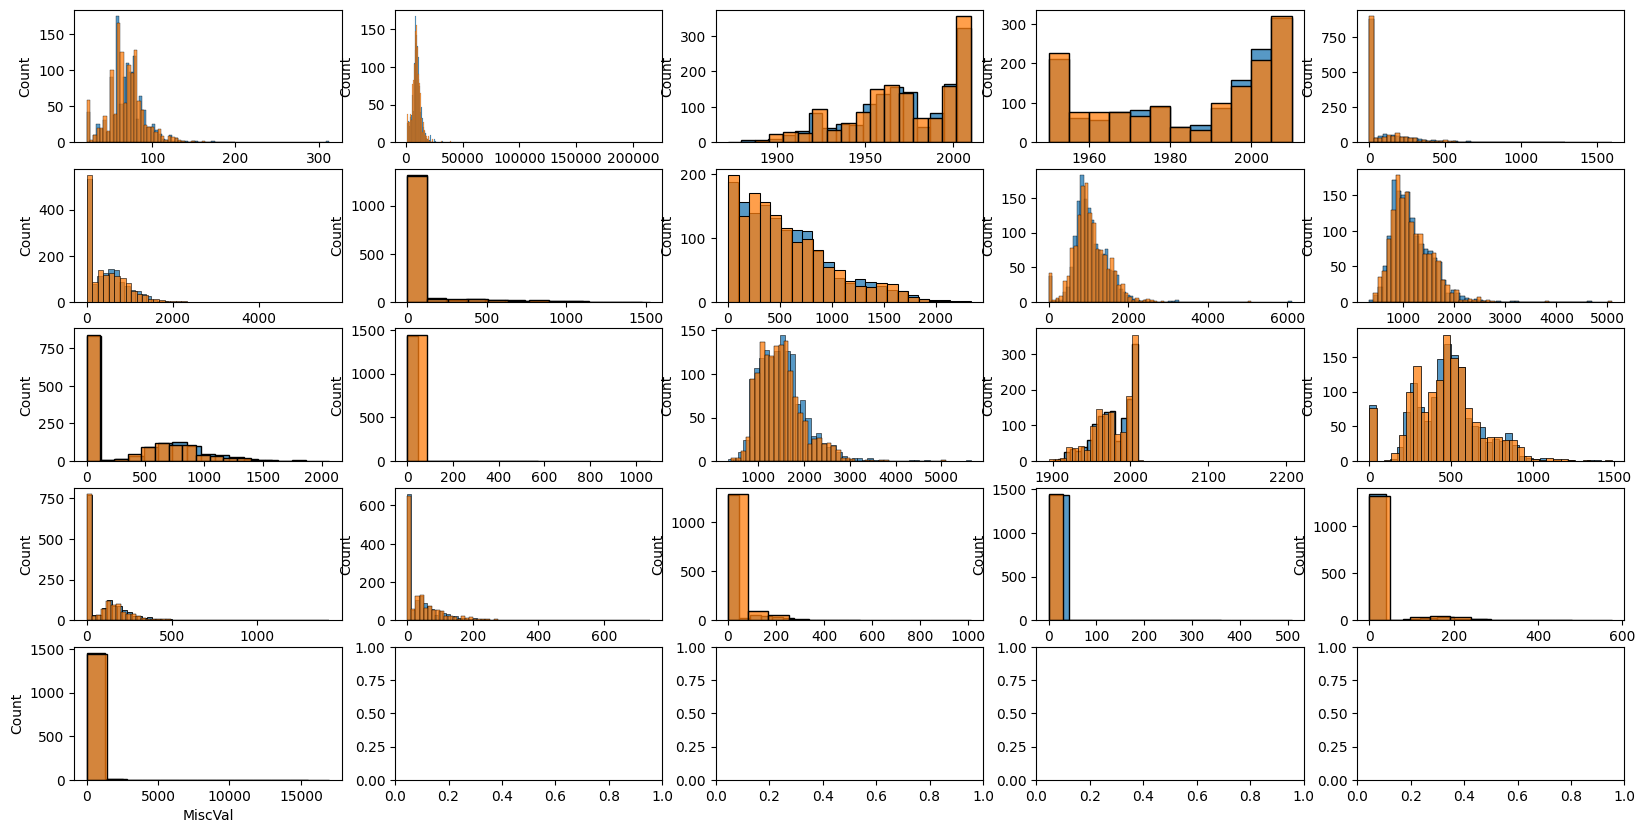

In [ ]:
#Visualize Distribuion of Discrete data
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))

for i, feature in enumerate(discrete_data):
  sns.histplot(x=feature, data=train_dataset, ax=axes[i//5, i%5])
  sns.histplot(x=feature, data=test_dataset, ax=axes[i//5, i%5])
plt.show()

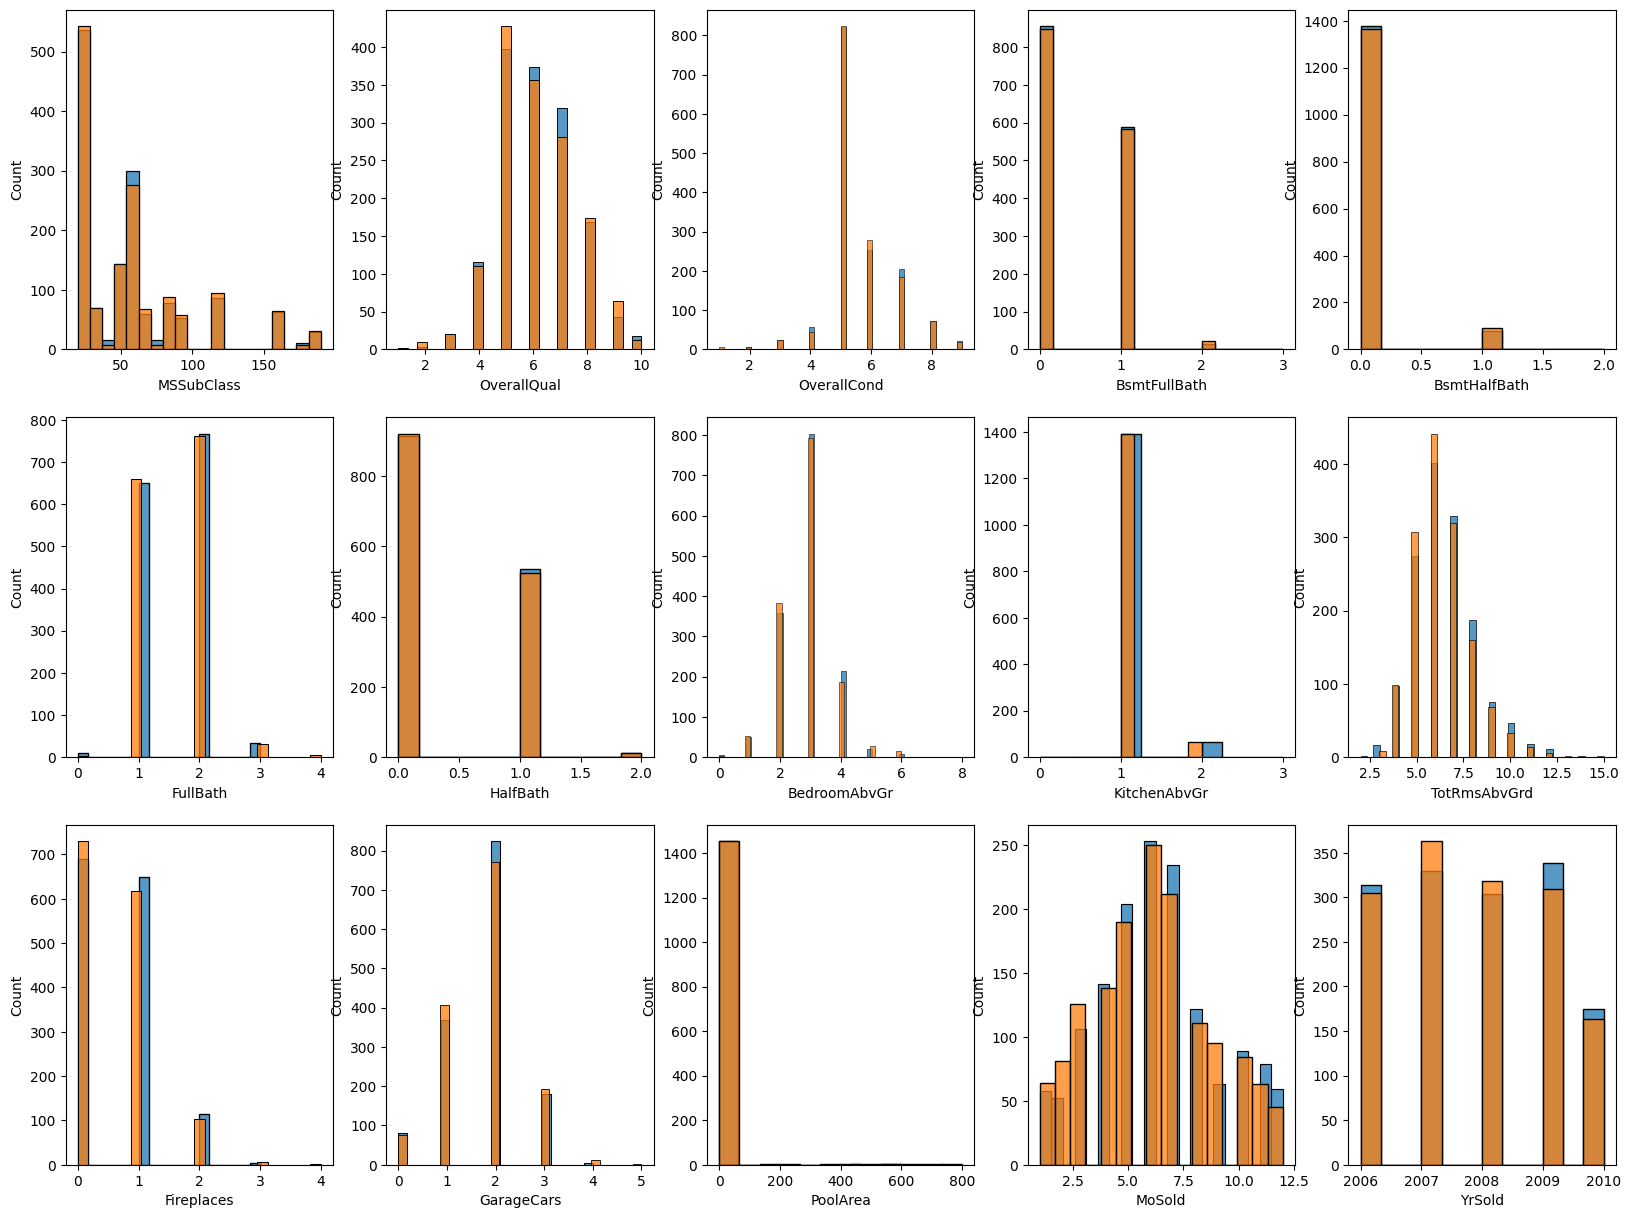

In [ ]:
#Visualize Distribution of Continuous data
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 15))

for i, feature in enumerate(continuous_data):
  sns.histplot(x=feature, data=train_dataset, ax=axes[i//5, i%5])
  sns.histplot(x=feature, data=test_dataset, ax=axes[i//5, i%5])

##Checking Skewness

In [ ]:
skewness_train = train_dataset[numerical_data].skew().sort_values(ascending=False)
skewness_test = test_dataset[numerical_data].skew().sort_values(ascending=False)

avg_skewness = (skewness_train + skewness_test) / 2
avg_skewness = avg_skewness.sort_values(ascending=False)

print(avg_skewness)

MiscVal         22.28
PoolArea        17.51
LowQualFinSF    12.59
3SsnPorch       11.41
LotArea          7.66
KitchenAbvGr     4.28
BsmtFinSF2       4.15
ScreenPorch      3.96
BsmtHalfBath     3.94
EnclosedPorch    3.88
MasVnrArea       2.60
OpenPorchSF      2.53
WoodDeckSF       1.84
1stFlrSF         1.47
BsmtFinSF1       1.43
LotFrontage      1.41
MSSubClass       1.38
GrLivArea        1.25
TotalBsmtSF      1.17
BsmtUnfSF        0.92
2ndFlrSF         0.86
TotRmsAbvGrd     0.76
Fireplaces       0.73
HalfBath         0.70
BsmtFullBath     0.62
OverallCond      0.57
BedroomAbvGr     0.32
GarageArea       0.24
OverallQual      0.20
MoSold           0.20
FullBath         0.17
YrSold           0.13
GarageCars      -0.22
GarageYrBlt     -0.40
YearRemodAdd    -0.45
YearBuilt       -0.60
dtype: float64


###Skew values with more than 1 or -1 will need transformation

<Axes: xlabel='SalePrice', ylabel='Count'>

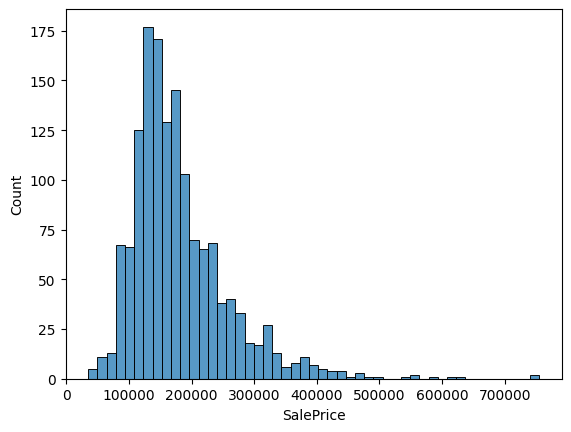

In [ ]:
sns.histplot(x='SalePrice', data=train_dataset)

##Correlation Comparison

<Axes: >

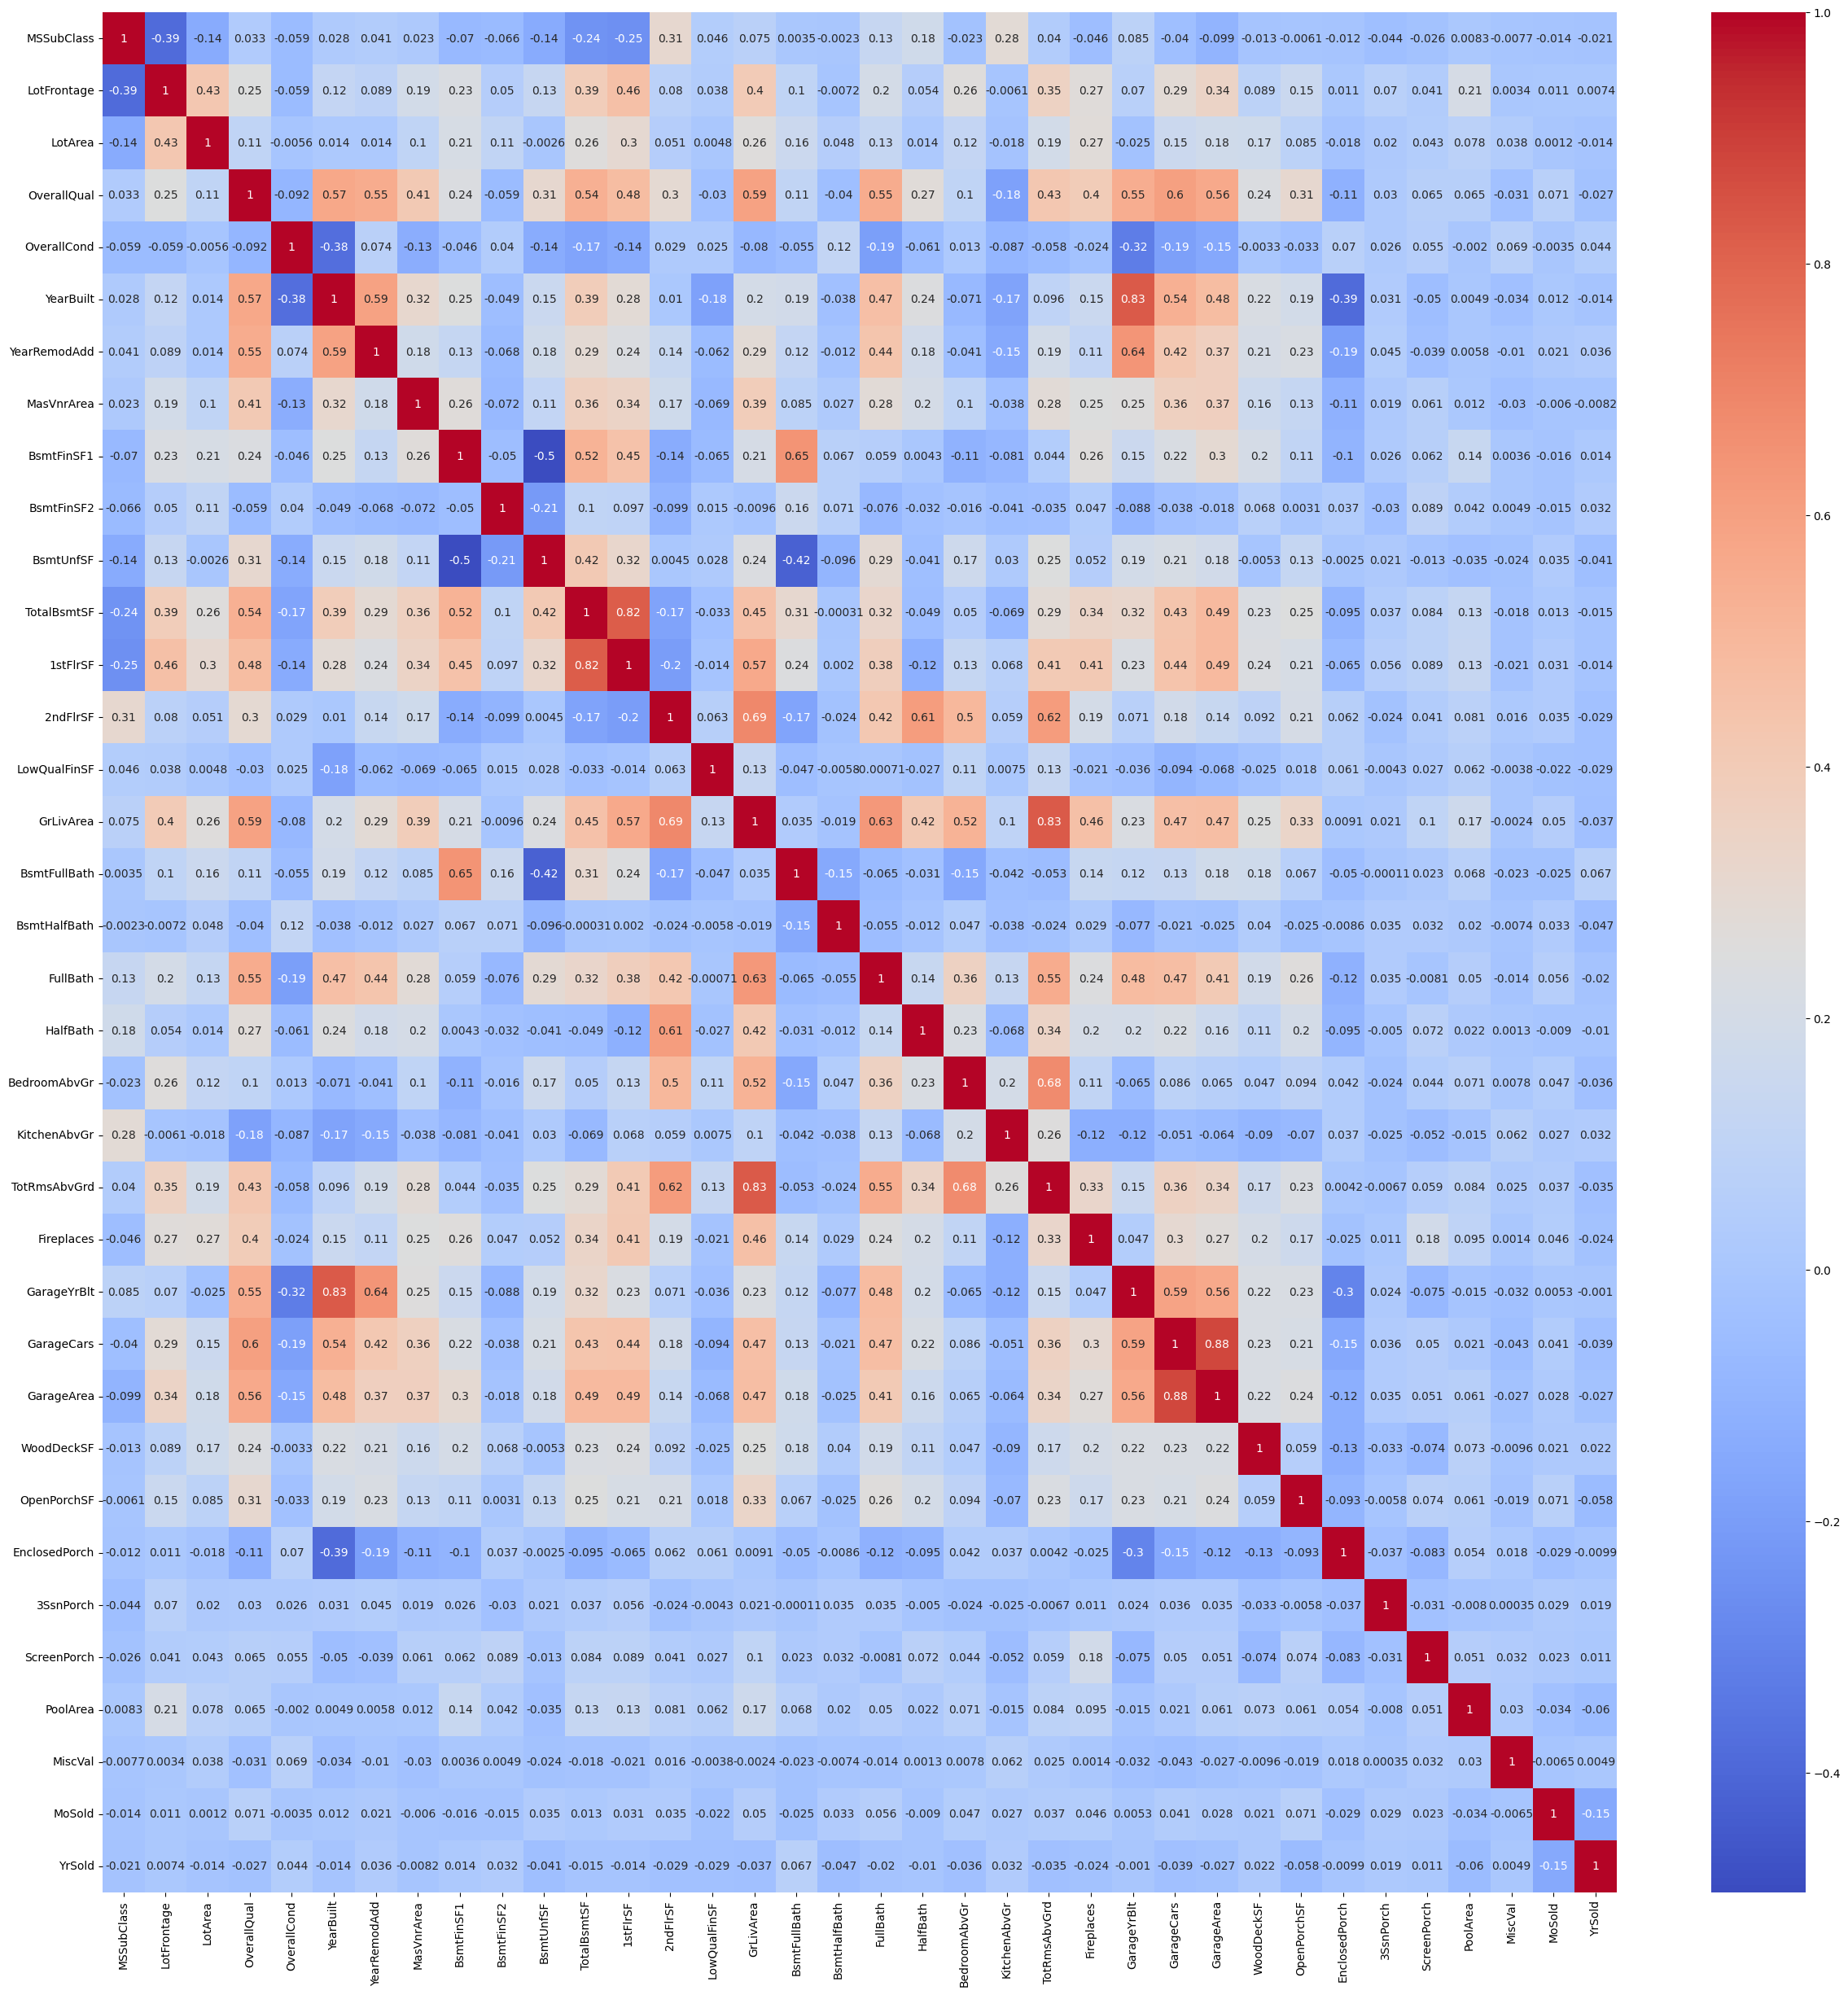

In [ ]:
#Check Correlation between each feature
numerical_feature = pd.DataFrame(data=train_dataset[numerical_data])

corr_data = numerical_feature.corr(method='pearson')
plt.figure(figsize=(30,30))
sns.heatmap(data= corr_data, cmap='coolwarm', annot=True, fmt='.2g')

There is a strong positive correlation between

    1. GarageArea and GarageCars.

    2. 1stFlrSF and TotalBsmtSF.

    3. GrLivArea and TotRmsAbvGrd.

we can consider removing one of them or using PCA to select the most important features

<Axes: >

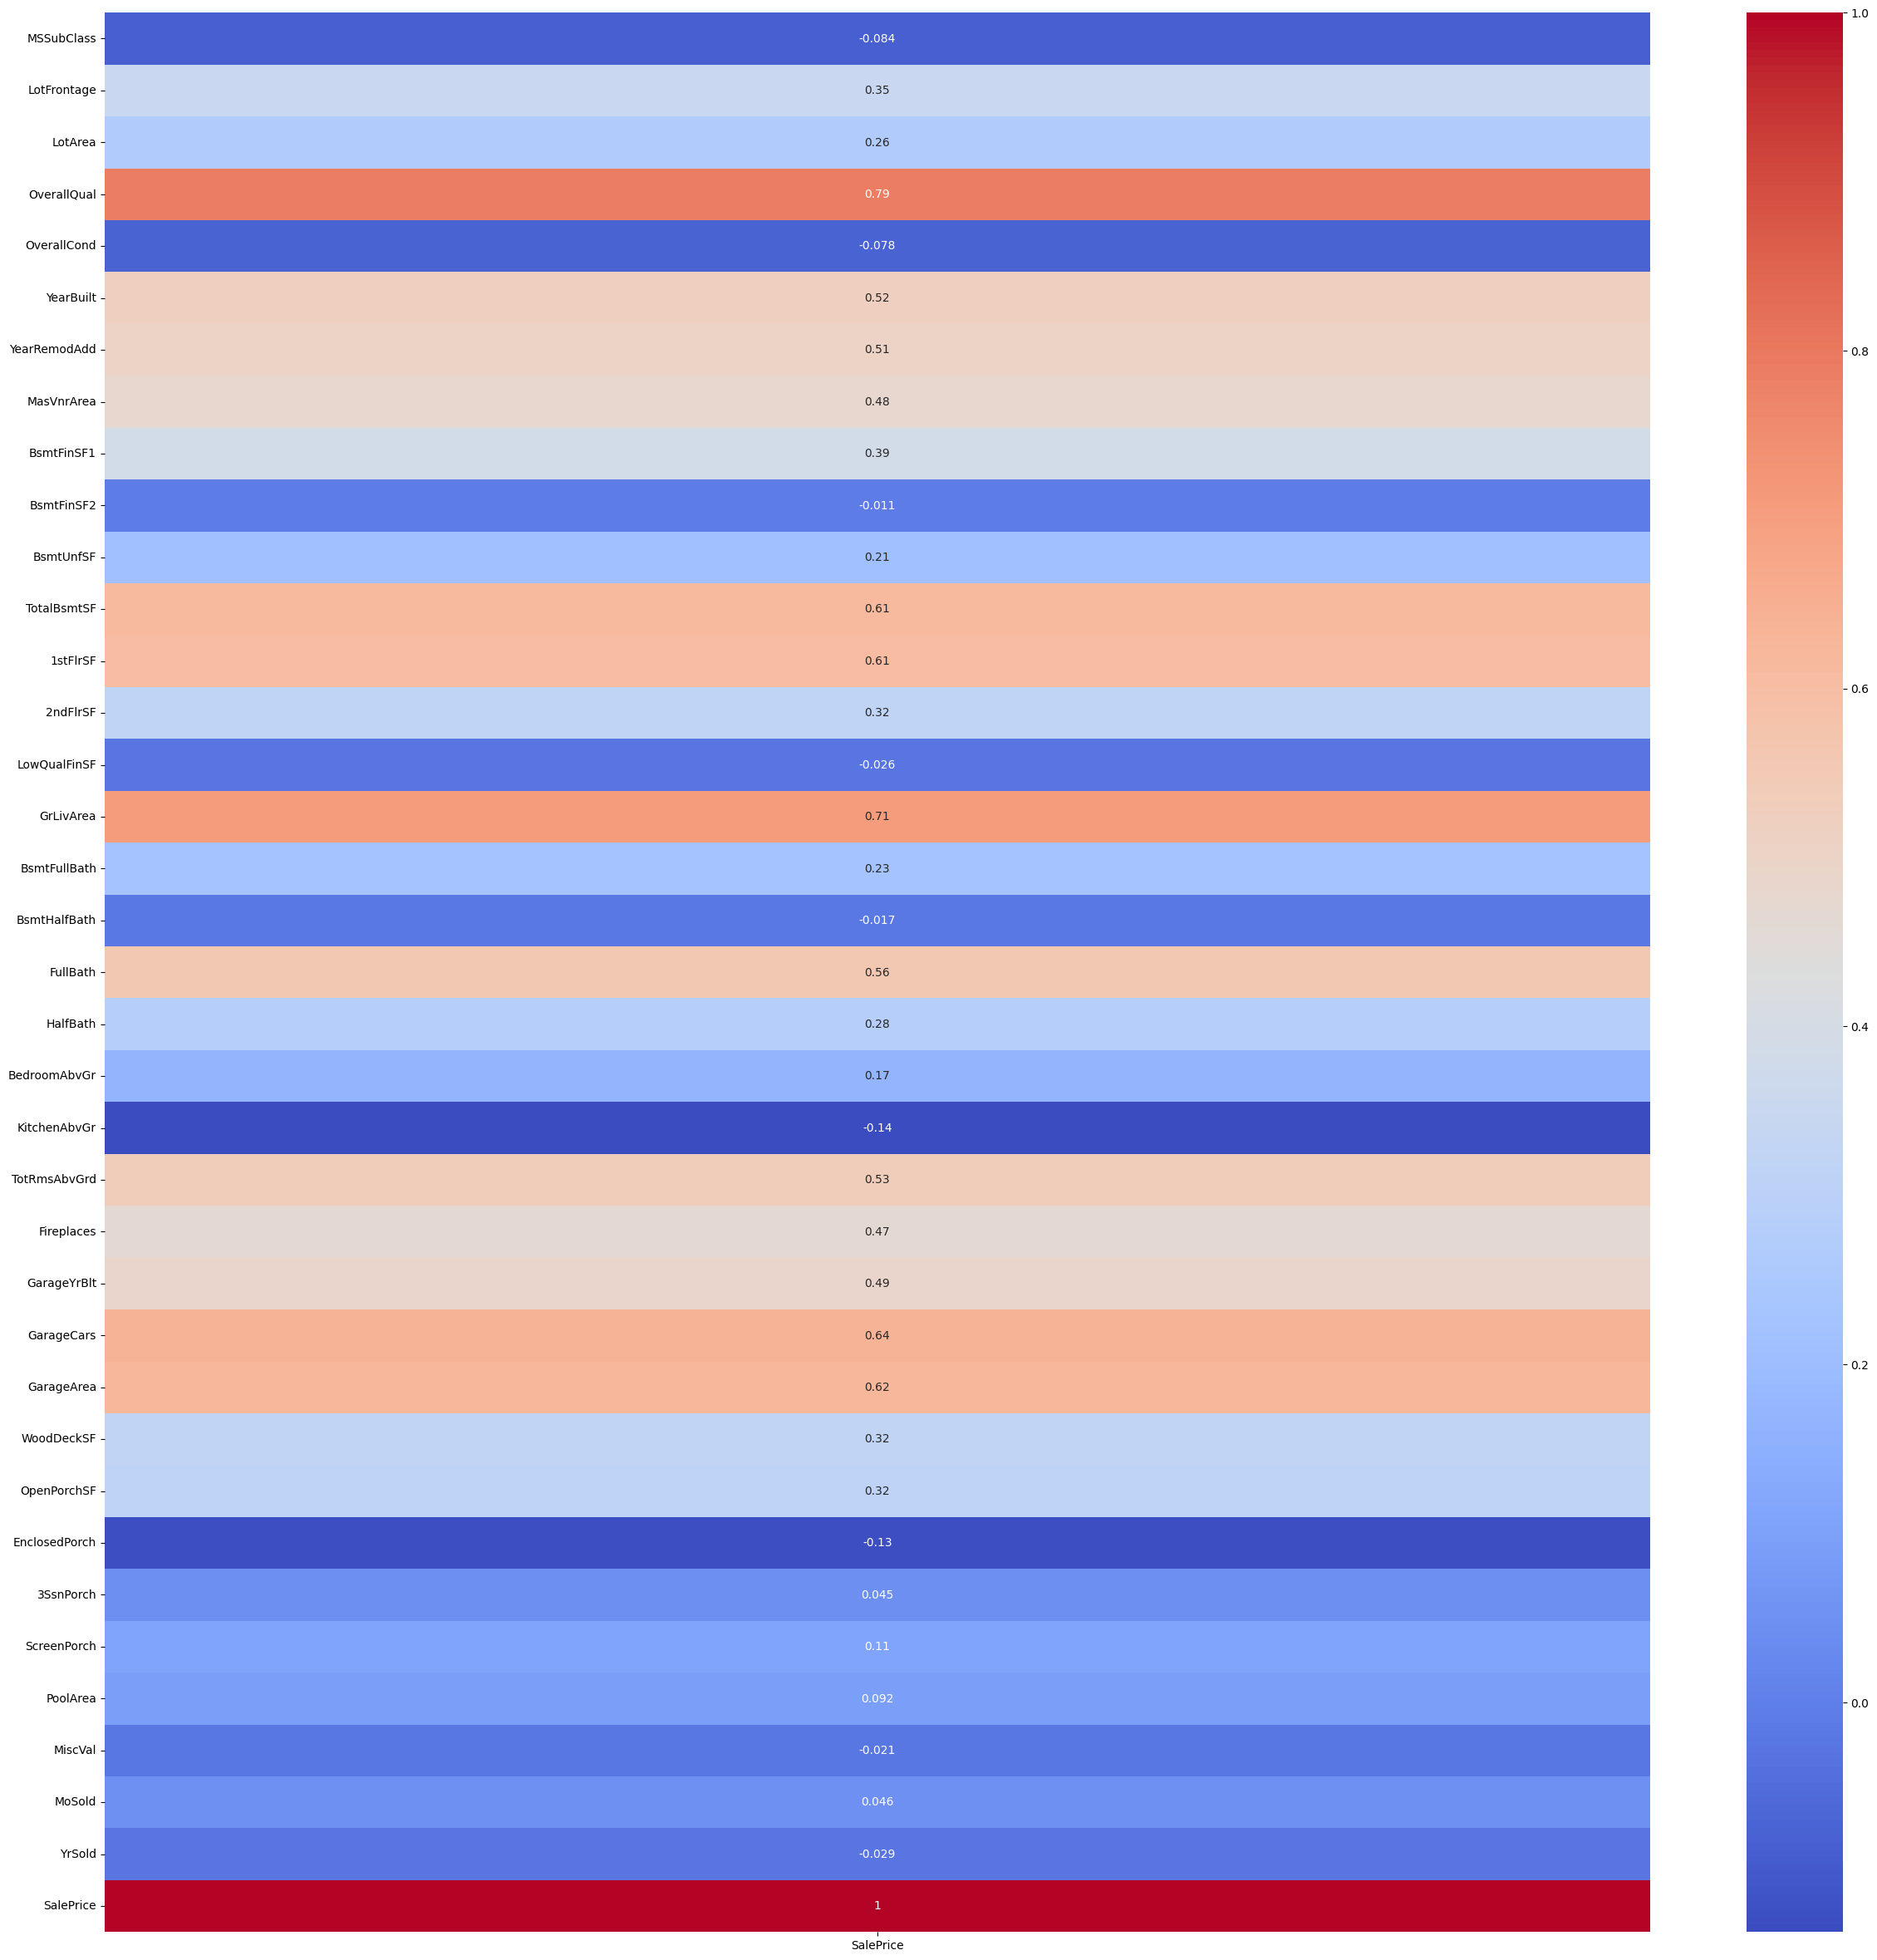

In [ ]:
numerical_feature['SalePrice'] = train_dataset['SalePrice']

corr_data = numerical_feature.corr(method='pearson')
corr_data = corr_data[['SalePrice']]

plt.figure(figsize=(30,30))
sns.heatmap(data= corr_data, cmap='coolwarm', annot=True, fmt='.2g')

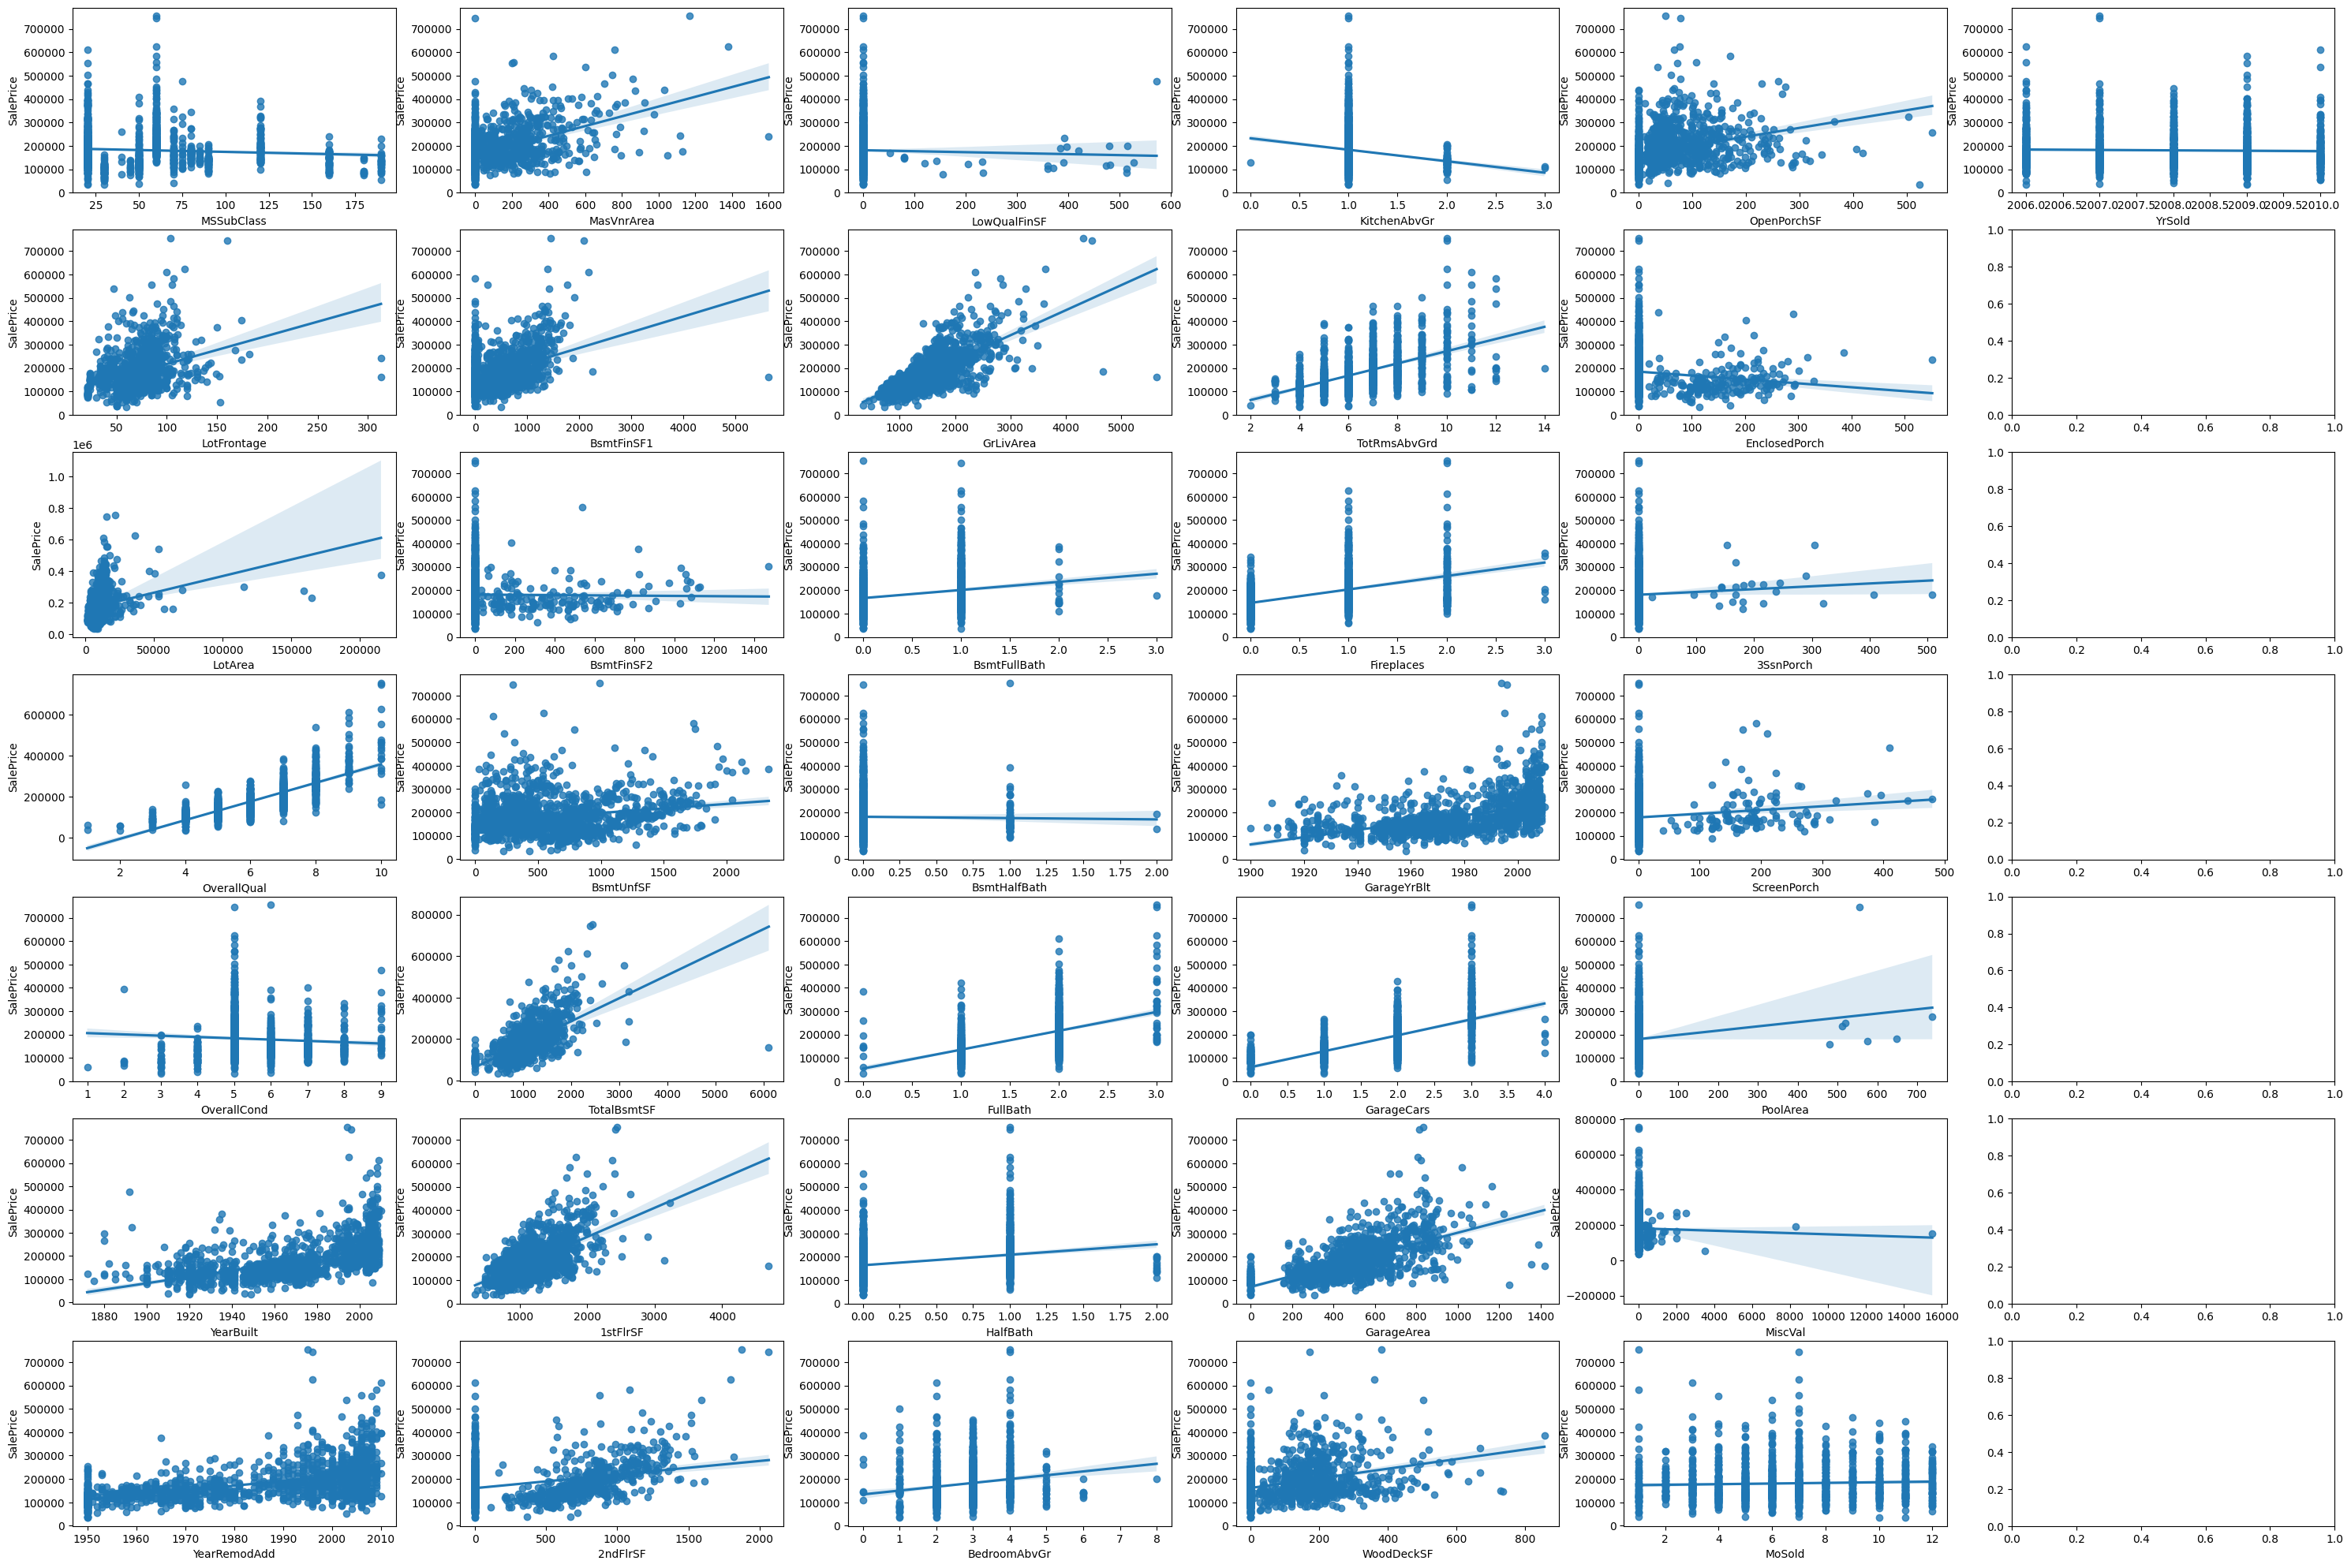

In [ ]:
# LINEARITY USING SCATTER PLOT

fig , axes = plt.subplots(nrows=7, ncols=6, figsize=(37,25))

for i , feature in enumerate(numerical_data):
    sns.regplot(data= train_dataset, x= feature, y= 'SalePrice', ax= axes[i%7, i//7])

plt.show()

#Feature Engineering

##Drop Columns

In [ ]:
#Drop Columns With Many Null Values
cols_with_many_nulls = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'LotFrontage']
combine_dataset = combine_dataset.drop(labels=cols_with_many_nulls, axis=1)

# NEXT DROP COLUMNS WITH MANY ZERO VALUES
cols_with_many_zero = ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea']
combine_dataset = combine_dataset.drop(labels=cols_with_many_zero, axis=1)

# LAST DROP COLUMNS WITH DOMINANT 1 LABEL
cols_with_dominant_label = ['Id','RoofMatl', 'Street', 'Condition2', 'Utilities', 'Heating']
combine_dataset = combine_dataset.drop(labels=cols_with_dominant_label, axis=1)

combine_dataset.info()




<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotArea        2919 non-null   int64  
 3   LotShape       2919 non-null   object 
 4   LandContour    2919 non-null   object 
 5   LotConfig      2919 non-null   object 
 6   LandSlope      2919 non-null   object 
 7   Neighborhood   2919 non-null   object 
 8   Condition1     2919 non-null   object 
 9   BldgType       2919 non-null   object 
 10  HouseStyle     2919 non-null   object 
 11  OverallQual    2919 non-null   int64  
 12  OverallCond    2919 non-null   int64  
 13  YearBuilt      2919 non-null   int64  
 14  YearRemodAdd   2919 non-null   int64  
 15  RoofStyle      2919 non-null   object 
 16  Exterior1st    2918 non-null   object 
 17  Exterior2nd    2918 non-null   object 
 18  MasVnrArea   

##Temporal Variable

In [ ]:
# FIND ALL DATE FEATURE
year_feature = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

for feature in year_feature:
    combine_dataset[feature] = combine_dataset['YrSold'] - combine_dataset[feature]

combine_dataset[year_feature].head(5)

,YearBuilt,YearRemodAdd,GarageYrBlt
0,5,5,5.00
1,31,31,31.00
2,7,6,7.00
3,91,36,8.00
4,8,8,8.00


##Filling Missing Values

In [ ]:
# Step 1: Check which ones have missing values
missing_categoricals = [col for col in categorical_data if train_dataset[col].isnull().sum() > 0]

# Step 2: Check mode for each
for col in missing_categoricals:
    mode_val = train_dataset[col].mode()[0]
    print(f"Feature: {col} | Missing: {train_dataset[col].isnull().sum()} | Mode: {mode_val}")



Feature: Alley | Missing: 1369 | Mode: Grvl
Feature: MasVnrType | Missing: 872 | Mode: BrkFace
Feature: BsmtQual | Missing: 37 | Mode: TA
Feature: BsmtCond | Missing: 37 | Mode: TA
Feature: BsmtExposure | Missing: 38 | Mode: No
Feature: BsmtFinType1 | Missing: 37 | Mode: Unf
Feature: BsmtFinType2 | Missing: 38 | Mode: Unf
Feature: Electrical | Missing: 1 | Mode: SBrkr
Feature: FireplaceQu | Missing: 690 | Mode: Gd
Feature: GarageType | Missing: 81 | Mode: Attchd
Feature: GarageFinish | Missing: 81 | Mode: Unf
Feature: GarageQual | Missing: 81 | Mode: TA
Feature: GarageCond | Missing: 81 | Mode: TA
Feature: PoolQC | Missing: 1453 | Mode: Gd
Feature: Fence | Missing: 1179 | Mode: MnPrv
Feature: MiscFeature | Missing: 1406 | Mode: Shed


In [ ]:
#Fill missing values with zeros
for feature in numerical_data:
  if feature not in cols_with_many_nulls and feature not in cols_with_many_zero:
    combine_dataset[feature] = combine_dataset[feature].fillna(0)

#Dealing with Categorical Features
dropped_cols = cols_with_dominant_label + cols_with_many_nulls
mode_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for feature in categorical_data:
  if feature not in dropped_cols:
    if feature not in mode_features:
      combine_dataset[feature] = combine_dataset[feature].fillna('Unknown')
    else:
      combine_dataset[feature] = combine_dataset[feature].fillna(combine_dataset[feature].mode()[0])

In [ ]:
combine_dataset.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SalePrice
count,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,1460.00
mean,57.14,10168.11,6.09,5.56,36.48,23.53,101.40,441.27,49.57,560.58,1051.42,1159.58,336.48,1500.76,0.43,0.06,1.57,0.38,2.86,1.04,6.45,0.60,28.06,1.77,472.71,93.71,47.49,23.10,16.06,6.21,2007.79,180921.20
std,42.52,7887.00,1.41,1.11,30.34,20.89,178.85,455.61,169.18,439.59,441.12,392.36,428.70,506.05,0.52,0.25,0.55,0.50,0.82,0.21,1.57,0.65,25.80,0.76,215.54,126.53,67.58,64.24,56.18,2.71,1.31,79442.50
min,20.00,1300.00,1.00,1.00,-1.00,-2.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,-200.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,20.00,7478.00,5.00,5.00,7.00,4.00,0.00,0.00,0.00,220.00,793.00,876.00,0.00,1126.00,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,5.00,1.00,320.00,0.00,0.00,0.00,0.00,4.00,2007.00,129975.00
50%,50.00,9453.00,6.00,5.00,35.00,15.00,0.00,368.00,0.00,467.00,989.00,1082.00,0.00,1444.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,25.00,2.00,480.00,0.00,26.00,0.00,0.00,6.00,2008.00,163000.00
75%,70.00,11570.00,7.00,6.00,54.50,43.00,163.50,733.00,0.00,805.00,1302.00,1387.50,704.00,1743.50,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,46.00,2.00,576.00,168.00,70.00,0.00,0.00,8.00,2009.00,214000.00
max,190.00,215245.00,10.00,9.00,136.00,60.00,1600.00,5644.00,1526.00,2336.00,6110.00,5095.00,2065.00,5642.00,3.00,2.00,4.00,2.00,8.00,3.00,15.00,4.00,114.00,5.00,1488.00,1424.00,742.00,1012.00,576.00,12.00,2010.00,755000.00


##Combining Variables and Creating New Features

In [ ]:
#Add New Feature 'Garage Efficiency'
combine_dataset['GarageEfficiency'] = combine_dataset['GarageArea'] / (combine_dataset['GarageCars'] +1)

# ADD NEW FEATURE TotalArea
combine_dataset['TotalArea'] = combine_dataset['GrLivArea'] + combine_dataset['TotalBsmtSF']

# DROP MULTICOLINEARITY FEATURE

multi_corr = ['GarageCars','GarageArea', 'TotalBsmtSF','GrLivArea', 'TotRmsAbvGrd']

combine_dataset = combine_dataset.drop(labels= multi_corr, axis=1)

combine_dataset.head(5)


,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageEfficiency,TotalArea
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,5,5,Gable,VinylSd,VinylSd,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706.00,Unf,0.00,150.00,Ex,Y,SBrkr,856,854,1.00,0.00,2,1,3,1,Gd,Typ,0,Attchd,5.00,RFn,TA,TA,Y,0,61,0,0,2,2008,WD,Normal,208500.00,182.67,2566.00
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,31,31,Gable,MetalSd,MetalSd,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.00,Unf,0.00,284.00,Ex,Y,SBrkr,1262,0,0.00,1.00,2,0,3,1,TA,Typ,1,Attchd,31.00,RFn,TA,TA,Y,298,0,0,0,5,2007,WD,Normal,181500.00,153.33,2524.00
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,7,6,Gable,VinylSd,VinylSd,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.00,Unf,0.00,434.00,Ex,Y,SBrkr,920,866,1.00,0.00,2,1,3,1,Gd,Typ,1,Attchd,7.00,RFn,TA,TA,Y,0,42,0,0,9,2008,WD,Normal,223500.00,202.67,2706.00
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,91,36,Gable,Wd Sdng,Wd Shng,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216.00,Unf,0.00,540.00,Gd,Y,SBrkr,961,756,1.00,0.00,1,0,3,1,Gd,Typ,1,Detchd,8.00,Unf,TA,TA,Y,0,35,272,0,2,2006,WD,Abnorml,140000.00,160.50,2473.00
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,8,8,Gable,VinylSd,VinylSd,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655.00,Unf,0.00,490.00,Ex,Y,SBrkr,1145,1053,1.00,0.00,2,1,4,1,Gd,Typ,1,Attchd,8.00,RFn,TA,TA,Y,192,84,0,0,12,2008,WD,Normal,250000.00,209.00,3343.00


In [ ]:
combine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        2919 non-null   int64  
 1   MSZoning          2919 non-null   object 
 2   LotArea           2919 non-null   int64  
 3   LotShape          2919 non-null   object 
 4   LandContour       2919 non-null   object 
 5   LotConfig         2919 non-null   object 
 6   LandSlope         2919 non-null   object 
 7   Neighborhood      2919 non-null   object 
 8   Condition1        2919 non-null   object 
 9   BldgType          2919 non-null   object 
 10  HouseStyle        2919 non-null   object 
 11  OverallQual       2919 non-null   int64  
 12  OverallCond       2919 non-null   int64  
 13  YearBuilt         2919 non-null   int64  
 14  YearRemodAdd      2919 non-null   int64  
 15  RoofStyle         2919 non-null   object 
 16  Exterior1st       2919 non-null   object 
 17  

#Feature Transformation

In [ ]:
#Let check the distribution of the features one more time


numerical_data_2 = [col for col in combine_dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()]

#Further Split Numerical data into discrete and continuous data
discrete_data_2 = [col for col in numerical_data_2 if len(combine_dataset[col].unique()) > 25]
continuous_data_2 = [col for col in numerical_data_2 if col not in discrete_data_2]

print(f'Number of Numerical Feature   : {len(numerical_data_2)}')
print(f'Number of Discrete Feature    : {len(discrete_data_2)}')
print(f'Number of Continous Feature   : {len(continuous_data_2)}')

Number of Numerical Feature   : 29
Number of Discrete Feature    : 17
Number of Continous Feature   : 12


In [ ]:
def get_outlier_counts_iqr(df):
    outlier_counts = {}
    for col in df.select_dtypes(include='number'):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        count = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_counts[col] = count
    return pd.Series(outlier_counts).sort_values(ascending=False)

outlier_summary = get_outlier_counts_iqr(combine_dataset)
print(outlier_summary)


EnclosedPorch       459
BsmtFinSF2          347
ScreenPorch         256
OverallCond         252
GarageEfficiency    216
MSSubClass          207
MasVnrArea          202
BsmtHalfBath        175
OpenPorchSF         159
KitchenAbvGr        134
LotArea             128
BedroomAbvGr         78
WoodDeckSF           67
SalePrice            61
TotalArea            55
BsmtUnfSF            53
1stFlrSF             42
BsmtFinSF1           15
Fireplaces           12
YearBuilt             9
2ndFlrSF              8
GarageYrBlt           6
FullBath              4
OverallQual           4
BsmtFullBath          2
YearRemodAdd          0
HalfBath              0
MoSold                0
YrSold                0
dtype: int64


In [ ]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower, upper)
    return df

for col in ['EnclosedPorch', 'BsmtFinSF2', 'LotArea', 'ScreenPorch', 'OverallCond']:
    combine_dataset = cap_outliers_iqr(combine_dataset, col)


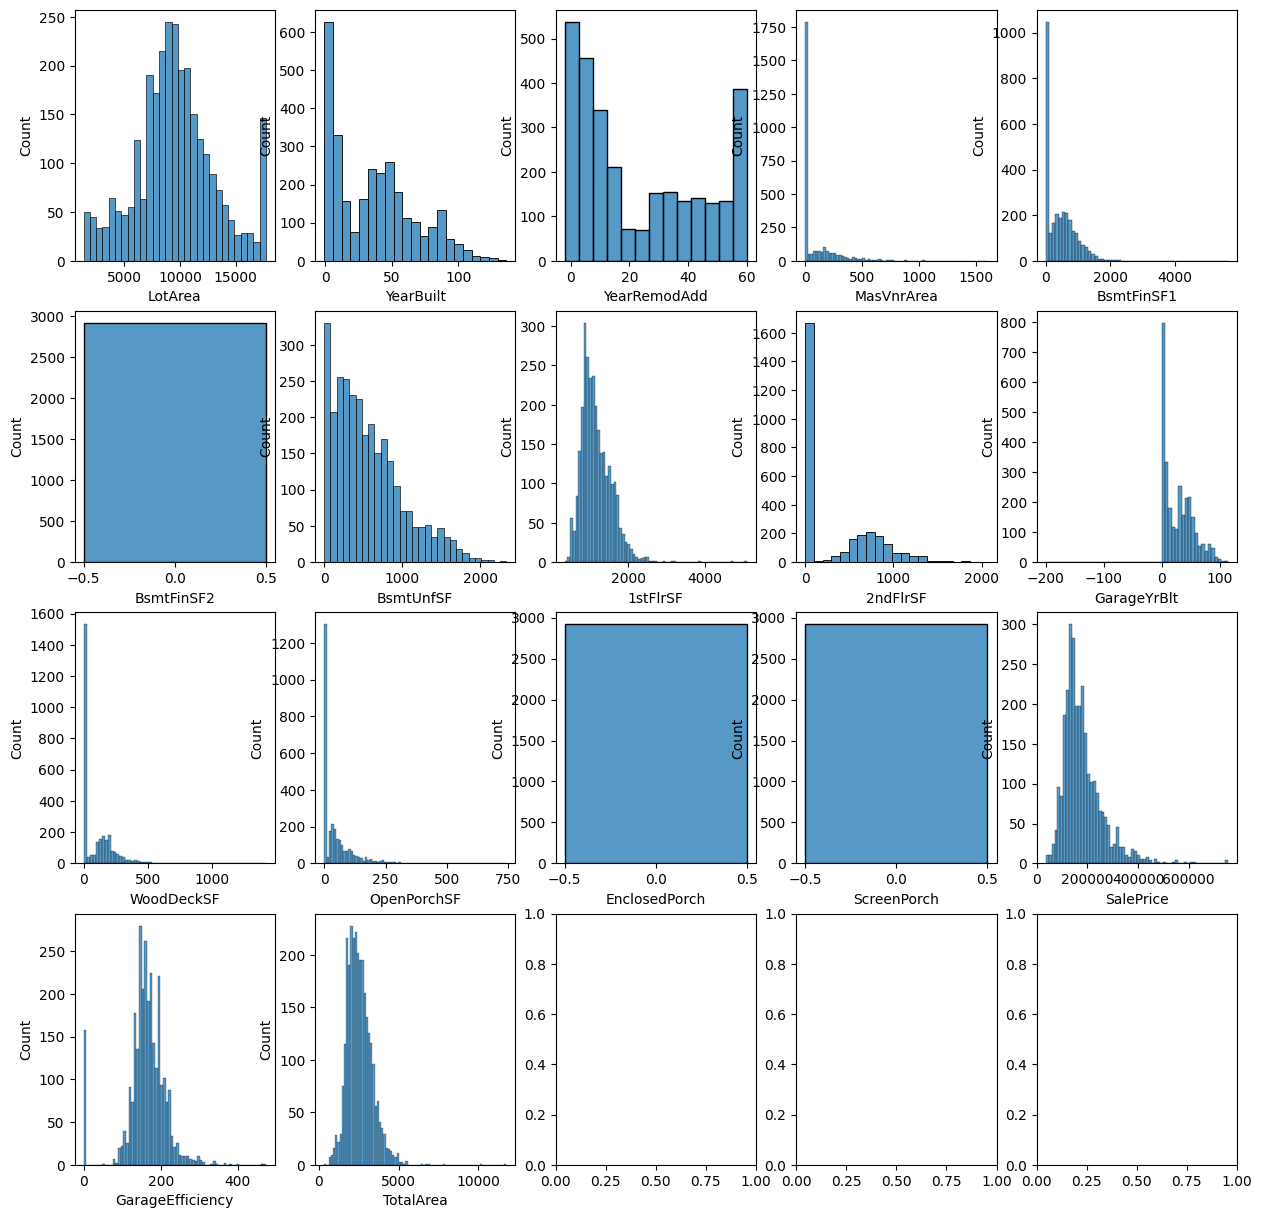

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15))

for i, feature in enumerate(discrete_data_2):
  sns.histplot(x=feature, data=combine_dataset, ax=axes[i//5, i%5])
plt.show()


In [ ]:
skewness = combine_dataset[numerical_data_2].skew().sort_values(ascending=False)


print(skewness)

KitchenAbvGr        4.30
BsmtHalfBath        3.93
MasVnrArea          2.61
OpenPorchSF         2.54
SalePrice           1.88
WoodDeckSF          1.84
TotalArea           1.51
1stFlrSF            1.47
BsmtFinSF1          1.43
MSSubClass          1.38
BsmtUnfSF           0.92
2ndFlrSF            0.86
Fireplaces          0.73
HalfBath            0.69
BsmtFullBath        0.63
YearBuilt           0.60
OverallCond         0.58
GarageYrBlt         0.45
YearRemodAdd        0.45
BedroomAbvGr        0.33
LotArea             0.20
OverallQual         0.20
MoSold              0.20
FullBath            0.17
YrSold              0.13
BsmtFinSF2          0.00
EnclosedPorch       0.00
ScreenPorch         0.00
GarageEfficiency   -0.79
dtype: float64


In [ ]:
#Columns to Transform have values greater than 1 or -1
cols_to_transform = ['LotArea', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF','WoodDeckSF', 'TotalArea', '1stFlrSF', 'BsmtFinSF1', 'MSSubClass']

for col in cols_to_transform:
  transformer = powerTransformer(method='yeo-johnson', standardize=True, copy=True)
  combine_dataset[[col]] = transformer.fit_transform(combine_dataset[[col]])

In [ ]:
skewness = combine_dataset[numerical_data_2].skew().sort_values(ascending=False)

print(skewness)

BsmtHalfBath        3.71
SalePrice           1.88
BsmtUnfSF           0.92
2ndFlrSF            0.86
Fireplaces          0.73
HalfBath            0.69
BsmtFullBath        0.63
YearBuilt           0.60
OverallCond         0.58
MasVnrArea          0.46
GarageYrBlt         0.45
YearRemodAdd        0.45
BedroomAbvGr        0.33
OverallQual         0.20
MoSold              0.20
FullBath            0.17
WoodDeckSF          0.14
YrSold              0.13
MSSubClass          0.07
TotalArea           0.03
BsmtFinSF2          0.00
ScreenPorch         0.00
EnclosedPorch       0.00
1stFlrSF           -0.00
LotArea            -0.01
OpenPorchSF        -0.03
BsmtFinSF1         -0.40
GarageEfficiency   -0.79
KitchenAbvGr       -2.06
dtype: float64


##Categorical Data Tranformation

###One Hot Encoder

In [ ]:
combine_dataset = pd.get_dummies(combine_dataset).reset_index(drop=True)
combine_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 239 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(210), float64(19), int64(10)
memory usage: 1.2 MB


##Re-Split The Dataset

In [ ]:
new_train_dataset = combine_dataset.iloc[:len(train_dataset), :]
new_test_dataset = combine_dataset.iloc[len(train_dataset):, :]

x_train = new_train_dataset.drop(labels='SalePrice', axis=1)

y_train = np.log1p(new_train_dataset['SalePrice'])

x_test = new_test_dataset.drop(labels=['SalePrice'], axis=1)

x_train.shape , y_train.shape, x_test.shape

((1460, 238), (1460,), (1459, 238))

##Feature Scaling

In [ ]:
cols_to_robust = [
    'BsmtHalfBath', 'KitchenAbvGr', 'GarageEfficiency',
    'BsmtUnfSF', '2ndFlrSF', 'Fireplaces', 'HalfBath', 'BsmtFullBath',
    'YearBuilt', 'OverallCond'
]

cols_to_zscore = [
    'GarageYrBlt', 'YearRemodAdd', 'MasVnrArea', 'BedroomAbvGr', 'OverallQual',
    'MoSold', 'FullBath', 'YrSold', 'WoodDeckSF', 'MSSubClass', 'LotArea', 'TotalArea',
    'OpenPorchSF', 'ScreenPorch', 'BsmtFinSF2', 'EnclosedPorch', '1stFlrSF',
    'BsmtFinSF1'
]

#Robust Scaling
robust_scaler = RobustScaler()
robust_scaler.fit(x_train[cols_to_robust])

x_train[cols_to_robust] = robust_scaler.transform(x_train[cols_to_robust])
x_test[cols_to_robust]  = robust_scaler.transform(x_test[cols_to_robust])

# ZSCORE NORM
zscore = StandardScaler()
zscore.fit(x_train[cols_to_zscore])

x_train[cols_to_zscore] = zscore.transform(x_train[cols_to_zscore])
x_test[cols_to_zscore]  = zscore.transform(x_test[cols_to_zscore])

x_train.shape , x_test.shape

((1460, 238), (1459, 238))

#Model Development

##Lazy Predict

In [ ]:
#Split the x_train and y_train

x_train_lazy , x_test_lazy , y_train_lazy , y_test_lazy = train_test_split(x_train, y_train, test_size=0.2, random_state=12, shuffle=True)

lazy_predict = LazyRegressor(verbose=0, random_state=12, regressors='all')

train_lazy, test_lazy = lazy_predict.fit(x_train_lazy, x_test_lazy, y_train_lazy, y_test_lazy)
test_lazy

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2409
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 25
[LightGBM] [Info] Start training from score 12.023467


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.37,0.88,0.14,0.22
GradientBoostingRegressor,0.35,0.88,0.14,0.59
HistGradientBoostingRegressor,0.35,0.88,0.14,0.34
LassoLarsIC,0.31,0.87,0.15,0.13
HuberRegressor,0.31,0.87,0.15,0.06
LassoLarsCV,0.31,0.87,0.15,0.05
LarsCV,0.31,0.87,0.15,0.09
ElasticNetCV,0.31,0.87,0.15,0.14
LassoCV,0.31,0.87,0.15,0.14


we can see above the best algorithm. Ridge and Linear Regression are better compare to each other. we can use them for Stacking-Models.

so, i want use Linear Model + Non-Linear Model Combination for Stacking Model .

Here my Combination :

Ridge Regression (Linear Model)

Linear Regression (Linear Model)

Lasso Regression (Linear Model)

Gradient Boosting Machine (Non-Linear Model)

XGBoost (Non-Linear Model)

LightGBM (Non-Linear Model)

CatBoost (Non-Linear Model)

##Use Optuna For HyperParameters

###Ridge Regression

In [ ]:
#Find best Alpha and Max_tier for Ridge
def Ridge_objective(trial):
  alpha = trial.suggest_float('alpha',0.1, 25)
  max_iter = trial.suggest_int('max_iter',150,2000)

  #Set Model
  model = Ridge(alpha=alpha, max_iter=max_iter,random_state=12)

  #Score Metrics
  score = cross_val_score(estimator=model, X=x_train, y=y_train, scoring='neg_root_mean_squared_error')

  return score.mean()

# BUILD A OPTUNA
study = optuna.create_study(direction='maximize')
study.optimize(func= Ridge_objective, n_trials=100)

print(f'Best CV    : {study.best_params}')
print(f'Best Score : {study.best_value}')

#GET BEST HYPERPARAMETERS
ridge_best_params = study.best_params

[I 2025-05-22 04:54:43,021] A new study created in memory with name: no-name-ca16aa21-92d8-48cf-b944-65012bd7cad1
[I 2025-05-22 04:54:43,397] Trial 0 finished with value: -0.1278271886074631 and parameters: {'alpha': 15.328006454230207, 'max_iter': 1561}. Best is trial 0 with value: -0.1278271886074631.
[I 2025-05-22 04:54:43,836] Trial 1 finished with value: -0.1310410886514052 and parameters: {'alpha': 2.9511005902969525, 'max_iter': 889}. Best is trial 0 with value: -0.1278271886074631.
[I 2025-05-22 04:54:43,981] Trial 2 finished with value: -0.12775675853831422 and parameters: {'alpha': 22.371001565690324, 'max_iter': 531}. Best is trial 2 with value: -0.12775675853831422.
[I 2025-05-22 04:54:44,360] Trial 3 finished with value: -0.1299631145352153 and parameters: {'alpha': 4.3636161351265095, 'max_iter': 1680}. Best is trial 2 with value: -0.12775675853831422.
[I 2025-05-22 04:54:45,177] Trial 4 finished with value: -0.12774826758585345 and parameters: {'alpha': 21.28940189183173

Best CV    : {'alpha': 20.205658377417667, 'max_iter': 1131}
Best Score : -0.1277452121331702


In [ ]:
#Build The Model
ridge = Ridge(alpha=ridge_best_params['alpha'], max_iter=ridge_best_params['max_iter'], random_state=12, solver='auto', fit_intercept=True)

#Fit The Model
ridge.fit(x_train, y_train)

Ridge(alpha=20.205658377417667, max_iter=1131, random_state=12)

##Feature Importance Of Ridge

In [ ]:
# This is to see useful features and useless features for Ridge
# useful_features = {} #Capture coefficients of high value
# useless_features = {} #Capure coefficients with values close to zero


###Check Feature Importance

In [ ]:
# coefficients = ridge.coef_
# features_importance = pd.DataFrame({
#     'feature':ridge.feature_names_in_,
#     'coefficient': coefficients
# })

# features_importance = features_importance.sort_values(by='coefficient', ascending=False)

# plt.figure(figsize=(15,15))
# plt.barh(y=features_importance['feature'], width=features_importance['coefficient'])
# plt.show()

Lets display features with coefficients close to zero

In [ ]:
# features_importance['coefficient'] = abs(features_importance['coefficient']) #First convert coefficients to positive value
# zero = features_importance[features_importance['coefficient'] < 0.001].sort_values(by='feature', ascending=True)

# #Put the Features in a Dictotionary
# for feature in zero['feature']:
#   useless_features[feature] = useless_features.get(feature, 0) +1

# #Put The High Coefficient into Dict
# threshold = 0.02
# high_coef = features_importance[features_importance['coefficient'] >= threshold].sort_values(by='coefficient', ascending=False) # SORT IT DESCENDING
# high_coef = high_coef.reset_index(drop=True)

# for i, feature in enumerate(high_coef['feature']):
#     useful_features[feature] = useful_features.get(feature, 0) + high_coef['coefficient'][i] # COEFFICIENTS WITH HIGHER WEIGHT WILL GET MORE POINTS/VALUES

# # DISPLAY FEATURE THAT HAS VALUE CLOSE TO ZERO
# zero


##Lasso Regression

In [ ]:
def lasso_objective(trial):
    # SET HYPERPARAMETERS VALUE RANGE
    alpha    = trial.suggest_float('alpha',0.1, 25)
    max_iter = trial.suggest_int('max_iter',150, 2000)

    # SET MODEL
    model = Lasso(alpha=alpha,
                  max_iter=max_iter,
                  random_state=10)

    # SCORE METRICS
    score = cross_val_score(estimator= model , X = x_train, y= y_train, scoring='neg_root_mean_squared_error')

    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(func=lasso_objective, n_trials=100)

print(f'Best CV: {study.best_params}')
print(f'Best Score: {study.best_value}')

lasso_best_params = study.best_params

[I 2025-05-22 04:55:25,175] A new study created in memory with name: no-name-27c2d8b0-eb59-4b8d-bc9b-2aeae6fa18e5
[I 2025-05-22 04:55:25,349] Trial 0 finished with value: -0.39922568603836983 and parameters: {'alpha': 19.864174860484873, 'max_iter': 1932}. Best is trial 0 with value: -0.39922568603836983.
[I 2025-05-22 04:55:25,482] Trial 1 finished with value: -0.39922568603836983 and parameters: {'alpha': 3.507226359000115, 'max_iter': 627}. Best is trial 0 with value: -0.39922568603836983.
[I 2025-05-22 04:55:25,622] Trial 2 finished with value: -0.39922568603836983 and parameters: {'alpha': 5.371333143638982, 'max_iter': 1356}. Best is trial 0 with value: -0.39922568603836983.
[I 2025-05-22 04:55:25,751] Trial 3 finished with value: -0.39922568603836983 and parameters: {'alpha': 10.473572714381305, 'max_iter': 739}. Best is trial 0 with value: -0.39922568603836983.
[I 2025-05-22 04:55:25,885] Trial 4 finished with value: -0.39922568603836983 and parameters: {'alpha': 13.97442247584

Best CV: {'alpha': 0.10091795853716137, 'max_iter': 787}
Best Score: -0.2150346116843982


In [ ]:
lasso = Lasso(alpha=lasso_best_params['alpha'], max_iter=lasso_best_params['max_iter'], random_state=12, fit_intercept=True)

lasso.fit(x_train, y_train)


Lasso(alpha=0.10091795853716137, max_iter=787, random_state=12)

##Linear Regression

In [ ]:
linear = LinearRegression(fit_intercept=True, positive=False)

linear.fit(x_train, y_train)


LinearRegression()

##Gradient Boosting Machine

In [ ]:
def gbm_objective(trial):
  n_estimators = trial.suggest_int('n_esitimators', 50,2000)
  learning_rate = trial.suggest_float('learning', 0.001,1)
  max_depth = trial.suggest_int('max_depth', 2,16)
  max_features = trial.suggest_int('max_features', 5, 60)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 25)

    # DECLARATE THE MODEL AND ITS HYPERPARAMETERS
  gbr = GradientBoostingRegressor(
      n_estimators      = n_estimators,
      learning_rate     = learning_rate,
      max_depth         = max_depth,
      min_samples_split = min_samples_split,
      max_features      = max_features,
      random_state      = 12
        )
  score = cross_val_score(estimator=gbr, X=x_train, y=y_train, scoring='neg_root_mean_squared_error')

  return score.mean()

#Hyperparameter Tuning with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(func=gbm_objective, n_trials=100)

print(f'Best Hyperparameter : {study.best_params}')
print(f'Best Score          : {study.best_value}')

#TAKE THE BEST PARAMETERS
gbm_best_params = study.best_params

[I 2025-05-22 04:58:16,136] A new study created in memory with name: no-name-125e8d56-83fe-4e8a-b66e-bff19cfca053
[I 2025-05-22 04:58:52,519] Trial 0 finished with value: -0.1789118031248367 and parameters: {'n_esitimators': 1962, 'learning': 0.6552053660775577, 'max_depth': 16, 'max_features': 49, 'min_samples_split': 23}. Best is trial 0 with value: -0.1789118031248367.
[I 2025-05-22 04:58:56,542] Trial 1 finished with value: -0.1470527854301899 and parameters: {'n_esitimators': 215, 'learning': 0.21422447096359482, 'max_depth': 13, 'max_features': 16, 'min_samples_split': 17}. Best is trial 1 with value: -0.1470527854301899.
[I 2025-05-22 04:59:00,072] Trial 2 finished with value: -0.14616464741838164 and parameters: {'n_esitimators': 209, 'learning': 0.010532565676601748, 'max_depth': 8, 'max_features': 23, 'min_samples_split': 23}. Best is trial 2 with value: -0.14616464741838164.
[I 2025-05-22 04:59:06,475] Trial 3 finished with value: -0.21628093792593703 and parameters: {'n_esi

Best Hyperparameter : {'n_esitimators': 1391, 'learning': 0.04486173212353153, 'max_depth': 3, 'max_features': 51, 'min_samples_split': 7}
Best Score          : -0.11930572810091292


In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=gbm_best_params['n_esitimators'],
    learning_rate=gbm_best_params['learning'],
    max_depth=gbm_best_params['max_depth'],
    min_samples_split=gbm_best_params['min_samples_split'],
    max_features=gbm_best_params['max_features'],
    random_state=12
)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.04486173212353153, max_features=51,
                          min_samples_split=7, n_estimators=1391,
                          random_state=12)

#XGBoost

In [ ]:

def xgb_objective(trial):
  n_estimators = trial.suggest_int('n_estimators',100, 2000)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
  max_depth = trial.suggest_int('max_depth',2,20)
  min_child_weight = trial.suggest_float('min_child_weight', 0.4, 10)
  subsample = trial.suggest_float('subsample',0.35,1)
  gamma = trial.suggest_float('gamma', 0.1,1)
  reg_alpha = trial.suggest_float('reg_alpha', 0.01,15)
  reg_lambda = trial.suggest_float('reg_lambda', 0.01,15)

  xgb_model = xgb.XGBRegressor(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_child_weight=min_child_weight,
      subsample=subsample,
      gamma=gamma,
      reg_alpha=reg_alpha,
      reg_lambda=reg_lambda,
      random_state=12
  )

  score = cross_val_score(estimator=xgb_model, X=x_train, y=y_train, scoring='neg_root_mean_squared_error')

  return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(func=xgb_objective, n_trials=100)

print(f'Best Hyperparameter : {study.best_params}')
print(f'Best Score          : {study.best_value}')

xgb_best_params = study.best_params


[I 2025-05-22 07:40:06,514] A new study created in memory with name: no-name-2149f5e9-b9c8-403e-94b6-29b610c788a9
[I 2025-05-22 07:40:40,451] Trial 0 finished with value: -0.1874694222867201 and parameters: {'n_estimators': 1387, 'learning_rate': 0.4948477570956504, 'max_depth': 17, 'min_child_weight': 7.05612236077959, 'subsample': 0.7030451782245766, 'gamma': 0.4884119780816818, 'reg_alpha': 11.130288056711558, 'reg_lambda': 13.750221148209867}. Best is trial 0 with value: -0.1874694222867201.
[I 2025-05-22 07:40:48,006] Trial 1 finished with value: -0.18011143357569098 and parameters: {'n_estimators': 1293, 'learning_rate': 0.7330661087892151, 'max_depth': 8, 'min_child_weight': 3.3853703428955715, 'subsample': 0.7720618800002013, 'gamma': 0.7100635810247797, 'reg_alpha': 3.6809642137534064, 'reg_lambda': 3.8451762021695233}. Best is trial 1 with value: -0.18011143357569098.
[I 2025-05-22 07:40:59,187] Trial 2 finished with value: -0.19385909576778082 and parameters: {'n_estimators'

Best Hyperparameter : {'n_estimators': 1085, 'learning_rate': 0.1436315679650726, 'max_depth': 11, 'min_child_weight': 2.019991808072777, 'subsample': 0.4110668829665389, 'gamma': 0.10183252334938095, 'reg_alpha': 0.5357354083004868, 'reg_lambda': 3.864232659132851}
Best Score          : -0.1320266514689144


In [ ]:
xgboost = xgb.XGBRegressor(
    n_estimators = xgb_best_params['n_estimators'],
    learning_rate = xgb_best_params['learning_rate'],
    max_depth = xgb_best_params['max_depth'],
    min_child_weight = xgb_best_params['min_child_weight'],
    subsample = xgb_best_params['subsample'],
    gamma = xgb_best_params['gamma'],
    reg_alpha = xgb_best_params['reg_alpha'],
    reg_lambda = xgb_best_params['reg_lambda'],
    random_state = 12
)

xgboost.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.10183252334938095, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1436315679650726,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2.019991808072777, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1085,
             n_jobs=None, num_parallel_tree=None, random_state=12, ...)

##CatBoost

In [ ]:
def catboost_objective(trial):
  params = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
    'depth': trial.suggest_int('depth', 3, 10),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    'max_bin': trial.suggest_int('max_bin', 10, 500),
    'eval_metric': 'RMSE',

    }

  cat = catboost.CatBoostRegressor(**params, random_state=12, verbose=0)

  score = cross_val_score(estimator=cat, X= x_train, y= y_train, scoring='neg_root_mean_squared_error')

  return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(func=catboost_objective, n_trials=50)

print(f'Best Params : {study.best_params}')
print(f'Best Scores : {study.best_value}')


catboost_best_params = study.best_params

[I 2025-05-22 08:24:01,536] A new study created in memory with name: no-name-5ab53fab-df09-487b-957e-d1e5becee46a
[I 2025-05-22 08:25:17,309] Trial 0 finished with value: -0.37934940642414433 and parameters: {'iterations': 857, 'learning_rate': 9.0277115912626e-05, 'depth': 8, 'l2_leaf_reg': 0.17705585011829647, 'subsample': 0.8855760416129094, 'colsample_bylevel': 0.5331060101656476, 'min_data_in_leaf': 33, 'max_bin': 331}. Best is trial 0 with value: -0.37934940642414433.
[I 2025-05-22 08:25:18,489] Trial 1 finished with value: -0.3968630688510827 and parameters: {'iterations': 151, 'learning_rate': 6.705763852388193e-05, 'depth': 3, 'l2_leaf_reg': 4.081891096184296e-05, 'subsample': 0.6843200780232477, 'colsample_bylevel': 0.9010537711828643, 'min_data_in_leaf': 2, 'max_bin': 104}. Best is trial 0 with value: -0.37934940642414433.
[I 2025-05-22 08:25:29,408] Trial 2 finished with value: -0.12319905238981221 and parameters: {'iterations': 748, 'learning_rate': 0.013776637916770194, '

Best Params : {'iterations': 669, 'learning_rate': 0.060151085157128324, 'depth': 5, 'l2_leaf_reg': 0.0007083689559886472, 'subsample': 0.5045442635728028, 'colsample_bylevel': 0.514631643872609, 'min_data_in_leaf': 8, 'max_bin': 163}
Best Scores : -0.11893344563738344


In [ ]:
cat = catboost.CatBoostRegressor(
    iterations=catboost_best_params['iterations'],
    learning_rate=catboost_best_params['learning_rate'],
    depth=catboost_best_params['depth'],
    l2_leaf_reg=catboost_best_params['l2_leaf_reg'],
    subsample=catboost_best_params['subsample'],
    colsample_bylevel=catboost_best_params['colsample_bylevel'],
    min_data_in_leaf=catboost_best_params['min_data_in_leaf'],
    max_bin=catboost_best_params['max_bin'],
    eval_metric='RMSE',
    random_state=12,
    verbose=0
)

cat.fit(x_train, y_train)

##LightGBM

In [ ]:
# FUNCTION TO FIND BEST HYPERPARAMETER
# def lgbm_objective(trial):

    # SET HYPERPARAMETERS VALUE RANGE
    # num_leaves        = trial.suggest_int('num_leaves',20,100)
    # max_depth         = trial.suggest_int('max_depth', 2, 15)
    # learning_rate     = trial.suggest_float('learning_rate', 0.001, 0.8)
    # n_estimators      = trial.suggest_int('n_estimators', 100, 2000)
    # min_child_weight  = trial.suggest_float('min_child_weight',1e-3, 1.0)
    # min_child_samples = trial.suggest_int('min_child_samples', 7, 20)
    # subsample         = trial.suggest_float('subsample', 0.4, 1)
    # reg_alpha         = trial.suggest_float('reg_alpha', 0.02, 15)
    # reg_lambda        = trial.suggest_float('reg_lambda', 0.02, 15)

    # # DECLARATE LGBM MODEL
    # lgbm = lightgbm.LGBMRegressor(boosting_type    ='gbdt',
    #                          num_leaves       = num_leaves,
    #                          max_depth        = max_depth,
    #                          learning_rate    = learning_rate,
    #                          n_estimators     = n_estimators,
    #                          min_child_weight = min_child_weight,
    #                          min_child_samples= min_child_samples,
    #                          subsample        = subsample,
    #                          reg_alpha        = reg_alpha,
    #                          reg_lambda       = reg_lambda)

    # METRICS EVALUATION
    # score = cross_val_score(estimator= lgbm, X= x_train, y= y_train, scoring='neg_root_mean_squared_error')

    # return score.mean()

# BUILD AND FIT OPTUNA
# study = optuna.create_study(direction='maximize')
# study.optimize(func= lgbm_objective, n_trials=200)

# print(f'Best Params : {study.best_params}')
# print(f'Best Scores : {study.best_value}')

# #BEST PARAMS
# lgbm_best_params = study.best_params

#Creating A Stacking Regressor

In [ ]:
cv_fold = KFold(n_splits=10, shuffle=True, random_state=12)

model = StackingRegressor(
    estimators=[
        ('Ridge', ridge),
        ('Lasso', lasso),
        ('LinearRegression', linear),       # USING LINEAR REGRESSION CAUSE A MODEL GET WORSE
        ('GradientBoostingRegressor', gbr),
        ('xgb', xgboost),
        #('lightgbm', lgbm),
        ('catboost', cat)
    ],
    cv = cv_fold
)
model.fit(x_train, y_train)

StackingRegressor(cv=KFold(n_splits=10, random_state=12, shuffle=True),
                  estimators=[('Ridge',
                               Ridge(alpha=20.205658377417667, max_iter=1131,
                                     random_state=12)),
                              ('Lasso',
                               Lasso(alpha=0.10091795853716137, max_iter=787,
                                     random_state=12)),
                              ('LinearRegression', LinearRegression()),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(learning_rate=0.04486173212353...
                                            learning_rate=0.1436315679650726,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=11,
                                            max_leaves=None,
                                            min_child_weight=2.019991808072777,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1085, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=12, ...)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7b761bd29150>)])

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.expm1(y_pred)

submission = pd.read_csv('/kaggle/input/home-data-for-ml-course/sample_submission.csv')   # LOAD SAMPLE SUBMISSION CSV

output = pd.DataFrame(y_pred, columns=['SalePrice'])
output = pd.concat([submission.iloc[:,0] , output], axis=1)
output.rename(columns={output.columns[0] : 'Id'}, inplace=True)

# SAVE SUBMISSION
output.to_csv('submission.csv', index=False)